# Tutorial 3 - Image windowing

Welcome to the third tutorial of this series!
In this notebook, we'll investigate the effect of image windowing on the structure function.
This is a simple image preprocessing trick that allows to slightly extend the range of wave vectors that can be analyzed with DDM, without modifying the experimental setup.

### Purpose

The goal of this tutorial is to demonstrate how to apply image windowing in DDM.
Specifically, we will:

0. Set up the workspace and import the libraries
    1. Set up the workspace.
    2. Give an overview of the sample under investigation.
    3. Import libraries.
1. Compute the structure function of image sequences using DDM.
    1. Load the image sequences.
    2. See the effect of windowing on the input images.
    3. Calculate the corresponding structure functions using windowing.
    4. Calculate the azimuthal averages.
2. Fit the azimuthal average to gain insights into the sample's dynamics and investigate the effect of image windowing.
    1. Estimate the parameters.
    2. Fit the data using a diffusive dynamics model.
    3. Observe the effect of image windowing on the limits of the technique.
    4. Fit the parameters obtained from the fit to the data to retrieve the diffusion coefficient of the particles.

This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the ["zeroth" tutorial](../Tutorial_0-Introduction/tutorial0.ipynb).
It also builds on top of the previous tutorials [1](../Tutorial_1-Particle_sizing/tutorial1.ipynb) and [2](../Tutorial_2-Melt/tutorial2.ipynb).

At the end of the notebook, there will be an optional (starred) section:

* (*): Figures for the image windowing section of the paper.

## 0. Initial setup

### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `DATASET` folder) in the directory containing these tutorials.

Your main directory tree should resemble the following:
```
.
├── DATASET
│   └── ...
├── Tutorial_3-Image_windowing
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of a dilute solution of polystyrene spheres (PS, nominal diameter 252 nm, Microparticles GmbH) dispersed in a glycerol aqueous solution ($c_{\text{gly}} = 21.5\%$) to prevent sedimentation.
The sample was prepared at a volume fraction $\phi=10^{-3}$ and loaded into a 0.3 $\times$ 3 $\times$ 50 mm glass capillary (Vitrocom).
The experiments were performed at $T \simeq 21^{\circ}\mathrm{C}$ (solvent viscosity $\eta = 1.78 \, \mathrm{mPa \, s}$).

The videos were acquired at 108 and 1 fps for the fast and slow acquisition, respectively, using a Nikon Eclipse Ti2 inverted microscope equipped with a Prime BSI Express CMOS camera (pixel size $6.5 \, \mathrm{µm}$) using a 20$\times$, NA 0.45 objective.
This gives an effective pixel size of $\delta_{px} = 6.5/20 \, \mathrm{µm} = 325 \, \mathrm{nm}$.
The image sequences are composed of 10000 frames each, 256$\times$256 pixels.

### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

In [1]:
%matplotlib notebook

import gc
import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# get rid of the 'too many open images' warning
mpl.rcParams.update({'figure.max_open_warning': 0})

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels.

In [2]:
# directory containing the videos
main_directory = '../DATASET/'

# high frame rate videos file names (including enclosing folder)
file_name_fast = 'PS_252nm_phi_1e-3_20x_NA_0-45/fast.nd2'

# create full paths
file_path_fast = os.path.join(main_directory, file_name_fast)

# low frame rate videos file names (including enclosing folder)
file_name_slow = 'PS_252nm_phi_1e-3_20x_NA_0-45/slow.nd2'

# create full paths
file_path_slow = os.path.join(main_directory, file_name_slow)

# list of labels
image_labels = [
    r'20x, NA$_o$ 0.45 (fast)',
    r'20x, NA$_o$ 0.45 (slow)',
]

## 1. Structure function calculation

### 1.A. Load and visualize images

As usual, we start by inspecting the image sequences.
We show the first frame of the fast and slow videos side by side.

<IPython.core.display.Javascript object>


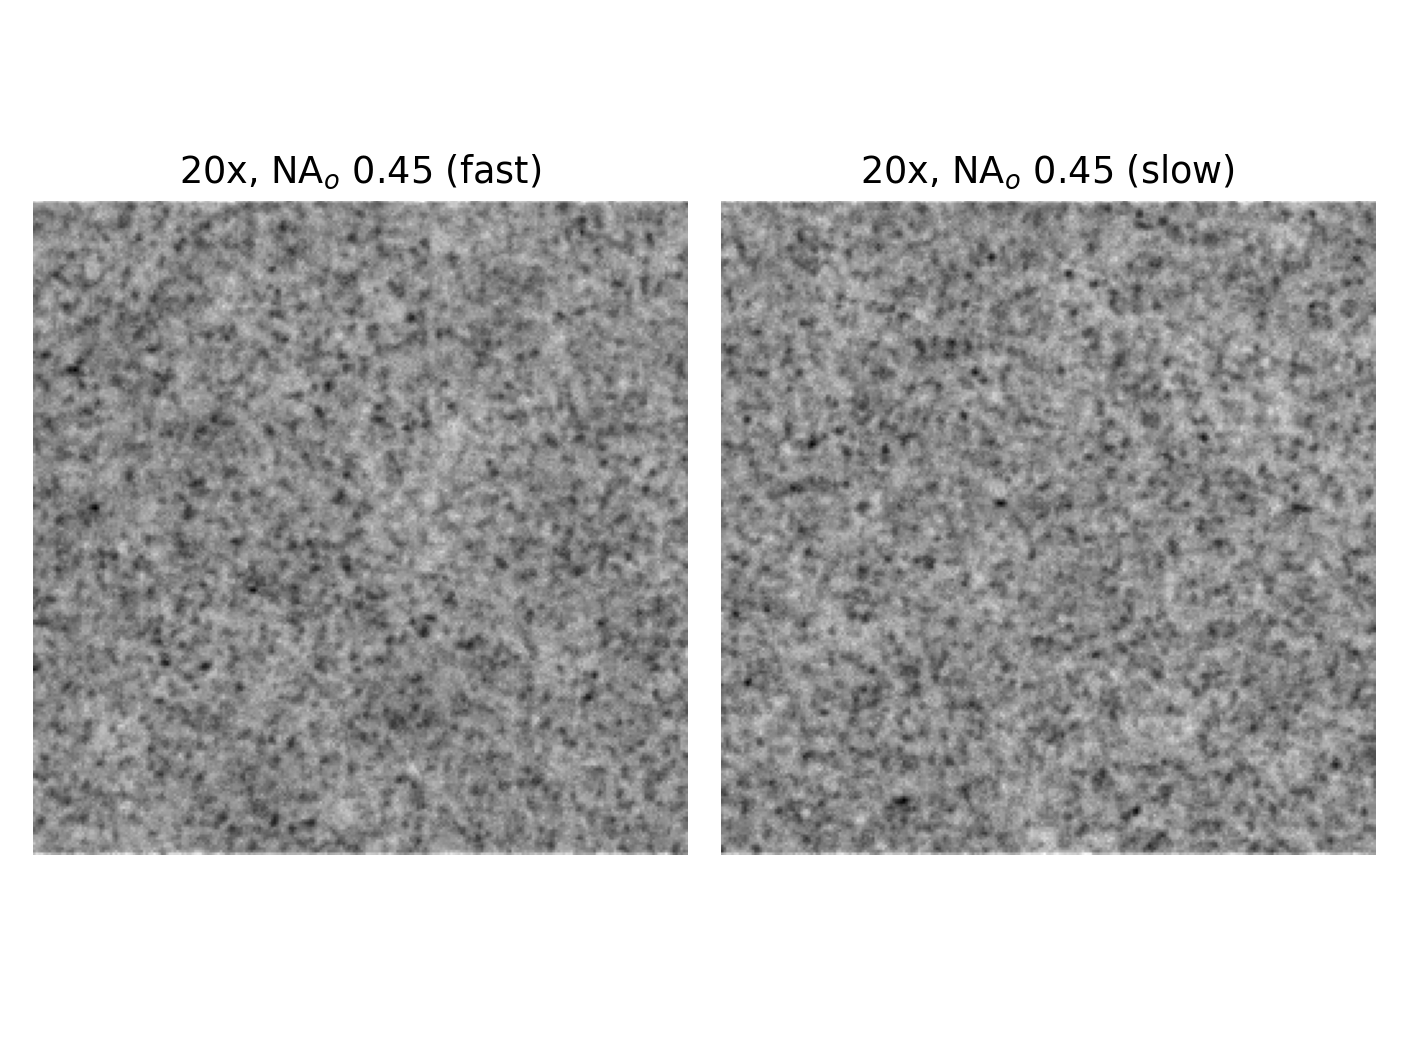

In [3]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=2)
axs = gs.subplots()

# read the images
images = [
    fd.read_images(file_path_fast, seq=[0])[0],
    fd.read_images(file_path_slow, seq=[0])[0],
]
images = np.array(images)

for ax, img, label in zip(axs.flatten(), images, image_labels):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

fig.tight_layout();

### 1.B. Effect of windowing

As we saw in the [first tutorial](../Tutorial_1-Particle_sizing/tutorial1.ipynb), at large wave vectors, the relaxation rate drops and reaches a lower plateau.
To understand why this happens, imagine the situation in which a particle (or a speckle) moves and crosses the image boundary.
The result is a spurious signal in the structure function, which appears as a band localized around the axis perpendicular to the direction of the motion.
The characteristic time of this extra contribution corresponds to the time needed for the particle (or speckle) to cross the boundary, i.e., $\tau_B \simeq R^2_{\text{app}} / D_0$.
Here, $D_0$ is the particle diffusion coefficient and $R_{\text{app}}$ is the *apparent* radius of the object.
This contribution has a greater impact on the dynamics measured at larger wave vectors, because the signal from the image "bulk" is lower.

Image windowing is a powerful preprocessing operation that allows to remove these artifacts in the structure function.
Similar to what is done in signal processing, the input is multiplied by a spatial window function, which is non-negative, smooth, and has zero value at the boundaries.
The specific shape of the window function is not crucial.
A possible choice is the 2D Blackman-Harris function $W(\mathbf{x}) = w(x) w(y)$, where:
$$
w(x) = \sum_{j=0}^3 (-1)^j a_j \cos\left( \frac{2 \pi j x}{M_x} \right) ,
$$
where $M_x$ is the number of pixels in the $x$ direction and $0 \le x < M_x$.
The coefficients are:
$$
a_0 = 0.3635819 \\
a_1 = 0.4891775 \\
a_2 = 0.1365995 \\
a_3 = 0.0106411.
$$

The window can be obtained using the `fastddm.window.blackman_harris()` function, which requires a tuple with at least two values with the shape of the image.
The last two values are read, so the shape of the whole image sequence is also fine.

In [4]:
# get the window for the image from the fast video
window = fd.window.blackman_harris(images[0].shape)

Let's see what is the effect of the window on the image (we use the fast movie for this example).

<IPython.core.display.Javascript object>


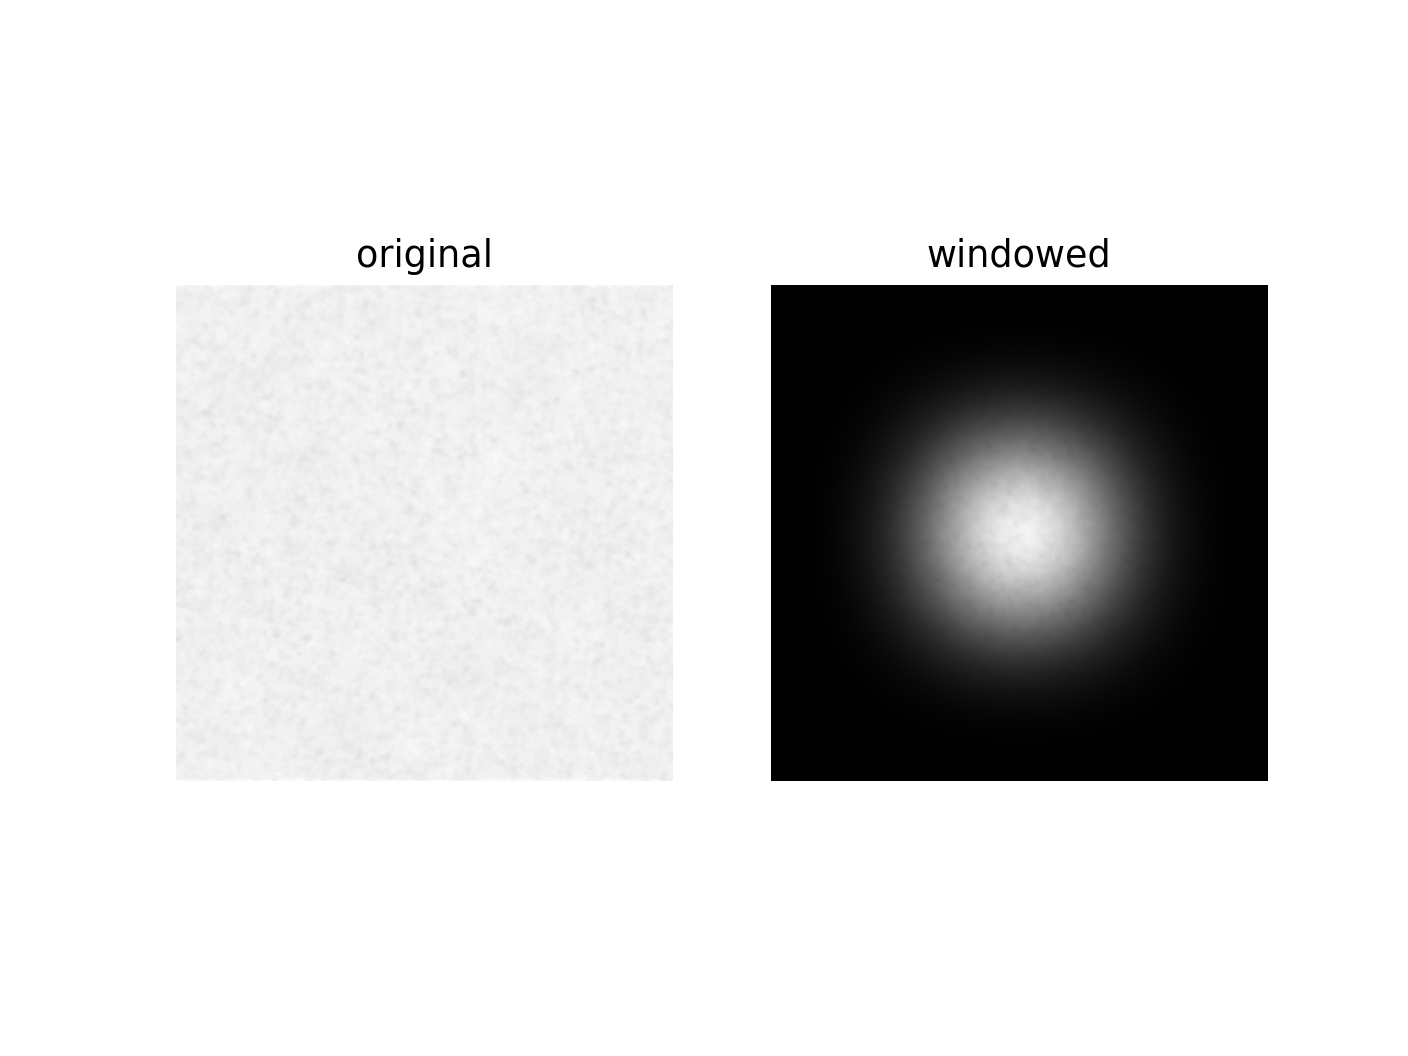

Text(0.5, 1.0, 'windowed')

In [5]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=2)
axs = gs.subplots()

# compute max
vmax = np.max(images[0])

# display the original image to the left
axs[0].imshow(images[0], cmap='gray', vmin=0, vmax=vmax)
axs[0].set_axis_off()
axs[0].set_title('original')

# display the windowed image to the right
axs[1].imshow(images[0] * window, cmap='gray', vmin=0, vmax=vmax)
axs[1].set_axis_off()
axs[1].set_title('windowed')

As you can observe, the window function enhances the information contained in the central part of the image and suppresses the signal from the boundaries, which is the source of the spurious contribution.
Let's try to use image windowing in the calculation of the structure function.

### 1.C-D. Structure function and azimuthal average calculation

The process here mirrors the one outlined in [tutorial2](../Tutorial_2-Melt/tutorial2.ipynb).
The only difference is the use here of the window function as an argument of the function for the calculation of the structure function.
Use the following cell to select the `core` and `mode` you wish to use for the calculation of the structure function.

In [6]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
CORE = 'py'
#CORE = 'cpp'
#CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

Here, we set the experimental parameters of the acquisition.

In [7]:
# experimental acquisition parameters
magnification = 20
pixel_size = 6.5 / magnification  # microns per pixel

frame_rate_fast = 108    # frames per second
frame_rate_slow = 1      # frames per second

To get a reference, we compute first the structure function and the azimuthal average using the original image sequences and melting the output from the fast and slow acquisitions.
Then, we repeat the process using image windowing.

In [8]:
print('--- Calculating structure functions and azimuthal averages... ---')

# analyze fast acquisition
# notify user on progress
print(f'Analyzing fast movie ...')
    
# read image sequence
img_seq = fd.read_images(file_path_fast)
    
# compute structure function
lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
# set pixel size and time delay
dqt.pixel_size = pixel_size
dqt.set_frame_rate(frame_rate_fast)
    
# compute azimuthal average
bins = int(len(dqt.ky) / 2)                       # number of bins
bin_range = (0, dqt.ky[-1])                       # bin range
ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
aa_fast = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
# delete unused variables
del img_seq, dqt
gc.collect()
    
# analyze slow acquisition
# notify user on progress
print(f'Analyzing slow movie ...')
    
# read image sequence
img_seq = fd.read_images(file_path_slow)
    
# compute structure function
lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
# set pixel size and time delay
dqt.pixel_size = pixel_size
dqt.set_frame_rate(frame_rate_slow)
    
# compute azimuthal average
bins = int(len(dqt.ky) / 2)                       # number of bins
bin_range = (0, dqt.ky[-1])                       # bin range
ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
aa_slow = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)

# melt the azimuthal averages
aa_melt = fd.azimuthalaverage.melt(aa_fast, aa_slow)
    
# delete unused variables
del img_seq, dqt
gc.collect();

--- Calculating structure functions and azimuthal averages... ---
Analyzing fast movie ...
Analyzing slow movie ...


We also resample the fast and the melt to simplify the plots.

In [9]:
# resample fast
new_taus = fd.lags.logspace_int(aa_fast.tau[-1] // aa_fast.tau[0], num=200) * aa_fast.tau[0]
aa_fast_resampled = aa_fast.resample(new_taus)

# resample melt
new_taus = fd.lags.logspace_int(aa_melt.tau[-1] // aa_melt.tau[0], num=200) * aa_melt.tau[0]
aa_melt_resampled = aa_melt.resample(new_taus)

Now, let's repeat the calculations using windowing.

In [10]:
print('--- Calculating structure functions and azimuthal averages (windowing)... ---')

# analyze fast acquisition
# notify user on progress
print(f'Analyzing fast movie ...')
    
# read image sequence
img_seq = fd.read_images(file_path_fast)
    
# compute structure function
lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
window = fd.window.blackman_harris(img_seq.shape)   # we use the blackman-harris window function
dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE, window=window)
    
# set pixel size and time delay
dqt.pixel_size = pixel_size
dqt.set_frame_rate(frame_rate_fast)
    
# compute azimuthal average
bins = int(len(dqt.ky) / 2)                       # number of bins
bin_range = (0, dqt.ky[-1])                       # bin range
ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
aa_fast_window = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
# delete unused variables
del img_seq, dqt
gc.collect()
    
# analyze slow acquisition
# notify user on progress
print(f'Analyzing slow movie ...')
    
# read image sequence
img_seq = fd.read_images(file_path_slow)
    
# compute structure function
lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
window = fd.window.blackman_harris(img_seq.shape)   # we use the blackman-harris window function
dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE, window=window)
    
# set pixel size and time delay
dqt.pixel_size = pixel_size
dqt.set_frame_rate(frame_rate_slow)
    
# compute azimuthal average
bins = int(len(dqt.ky) / 2)                       # number of bins
bin_range = (0, dqt.ky[-1])                       # bin range
ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
aa_slow_window = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)

# melt the azimuthal averages
aa_melt_window = fd.azimuthalaverage.melt(aa_fast_window, aa_slow_window)
    
# delete unused variables
del img_seq, dqt
gc.collect();

--- Calculating structure functions and azimuthal averages (windowing)... ---
Analyzing fast movie ...
Analyzing slow movie ...


Again, we resample the melt (with windowing) to ease plotting.

In [11]:
# resample melt window
new_taus = fd.lags.logspace_int(
    aa_melt_window.tau[-1] // aa_melt_window.tau[0],
    num=200
) * aa_melt_window.tau[0]
aa_melt_window_resampled = aa_melt_window.resample(new_taus)

## 2. Fit the data

To simplify the code, we create a list to group the azimuthal averages we want to fit, namely, the fast, melt, and melt window.

In [12]:
aa = [
    aa_fast,
    aa_melt,
    aa_melt_window,
]

# let's create a list also for the resampled azimuthal averages
aa_resampled = [
    aa_fast_resampled,
    aa_melt_resampled,
    aa_melt_window_resampled,
]

# and a list of labels
labels = [
    'fast',
    'melt',
    'window'
]

### 2.A. Estimate noise and amplitude

To give good starting points to the fit routine, we estimate the amplitude and noise term of the structure function.

In [13]:
# estimate noise and amplitude terms
Bq = []
Aq = []

for a in aa:
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit', num_points=5)
    Bq.append(B_est) 
    Aq.append(2 * a.var - B_est)

### 2.B. Fit with simple exponential

For particles undergoing Brownian motion, the intermediate scattering function is well-described by a simple exponential function:

$$
f(q, \Delta t) = \exp [- \Gamma(q) \Delta t] ,
$$
where $\Gamma(q) = D q^2$ is the relaxation rate and $D$ is the particles' diffusion coefficient.

We can use the `fastddm.fit_models.simple_exponential_model`, which implements the exponential function in the structure function model:

$$
d(q, \Delta t) = A(q) [1 - \exp(-\Gamma(q) \Delta t)] + B(q) .
$$

In [14]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 20

To initiate a fitting process with a reliable starting value for the relaxation rate, we can estimate $\tau = 1/\Gamma$ by first estimating the intermediate scattering function and determining the delay where it has a value of $1/\mathrm{e}$.

In [15]:
# initialize lists
fit_res = []
model_res = []

for a, B, A in zip(aa, Bq, Aq):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=True, return_model_results=True)
    fit_res.append(fr)
    model_res.append(mr)

Now, we can visualize the output from the fit. We first display the comparison of the intermediate scattering function $f(\Delta t; q)$ and the best fit, both obtained by inverting the structure function data and best fit with the resulting $A(q)$ and $B(q)$ from the fit

$$
f(q, \Delta t) = 1 - \frac{d(q, \Delta t) - B(q)}{A(q)}
$$

<IPython.core.display.Javascript object>


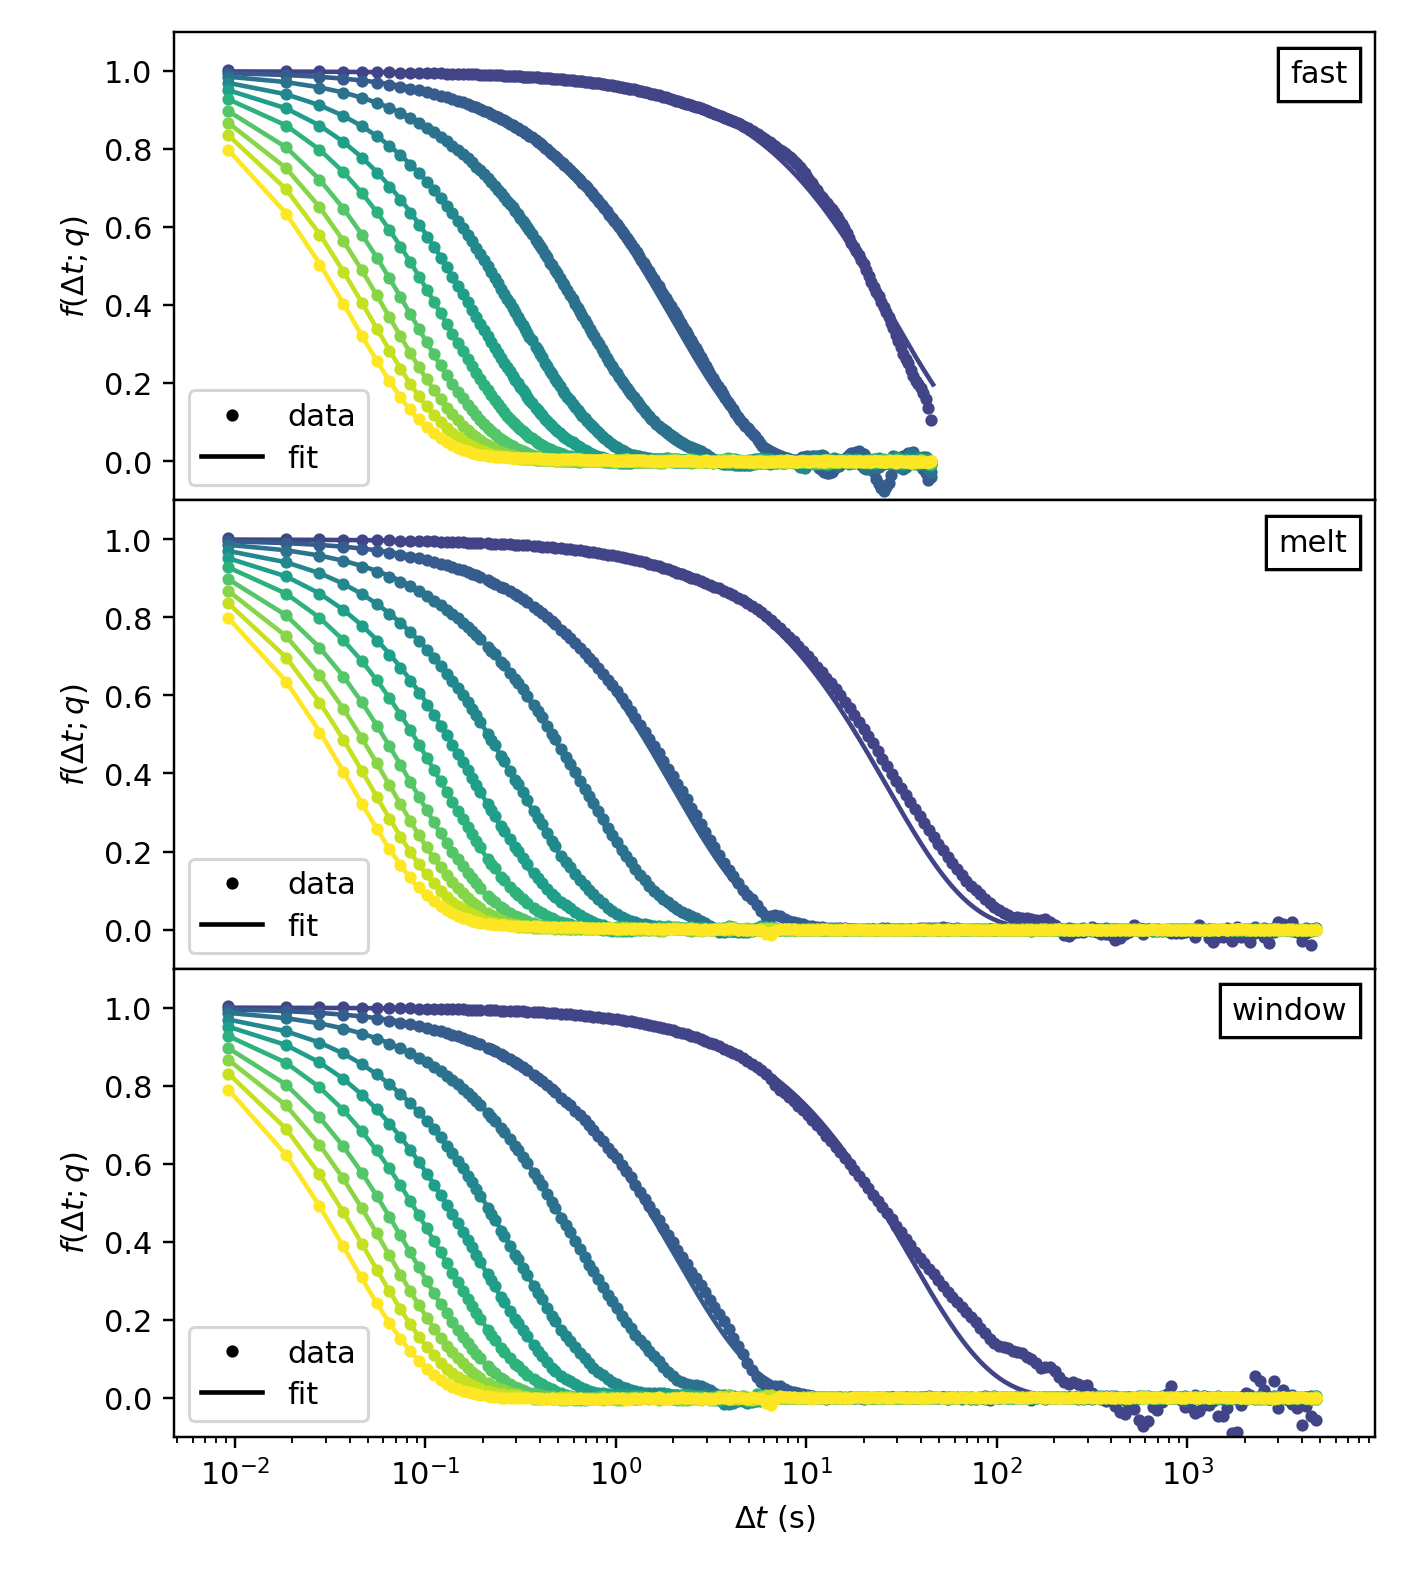

In [16]:
fig = plt.figure()
fig.set_figheight((len(aa) / 2) * fig.get_figheight())
gs = fig.add_gridspec(len(aa), hspace=0)
axs = gs.subplots(sharex=True)

# select range of wave vector indices
q_min = 0.17
q_max = 5.2

idx_min = np.argmin(np.abs(aa[0].k - q_min))
idx_max = np.argmin(np.abs(aa[0].k - q_max))
k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

cspace = color_space(len(k_list))

# plot curves
for ax, a, ar, fr, mr, l in zip(axs, aa, aa_resampled, fit_res, model_res, labels):
    for k_idx, c in zip(k_list, cspace):
        # calculate intermediate scattering function
        fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
        fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
        # plot
        ax.plot(ar.tau, fqt, '.', color=c)
        ax.plot(a.tau, fqt_fit, '-', color=c)
        
        # misc
        ax.set_ylabel(r'$f(\Delta t; q)$')
        ax.set_ylim(-0.1, 1.1)
        # label
        at = AnchoredText(l, prop=dict(size=10), frameon=True, loc='upper right')
        ax.add_artist(at)
        # custom legend
        custom_lines = [
            Line2D([0], [0], marker='.', linestyle='none', color='black', label='data'),
            Line2D([0], [0], linestyle='-', color='black', label='fit'),
        ]
        ax.legend(handles=custom_lines, labelspacing=0.4, loc='lower left')
        
axs[-1].set_xscale('log')
axs[-1].set_xlabel(r'$\Delta t$ (s)')

fig.tight_layout();

### 2.C. Effect of windowing on the output

Finally, we show the fit parameters, $\Gamma$, $A$, and $B$.
We also display the limits defined in [tutorial1](../Tutorial_1-Particle_sizing/tutorial1.ipynb).

In [17]:
# optical parameters
L = pixel_size * 256
NAo = 0.45
lambda0 = 0.53

# limits
q_min = 2 * np.pi / L
q_max = 2 * np.pi * NAo / lambda0
gamma_0 = 1 / aa[0].tau[0]    # also, gamma_0 = frame_rate
gamma_T = []
for a in aa:
    gamma_T.append(1 / a.tau[-1])

<IPython.core.display.Javascript object>


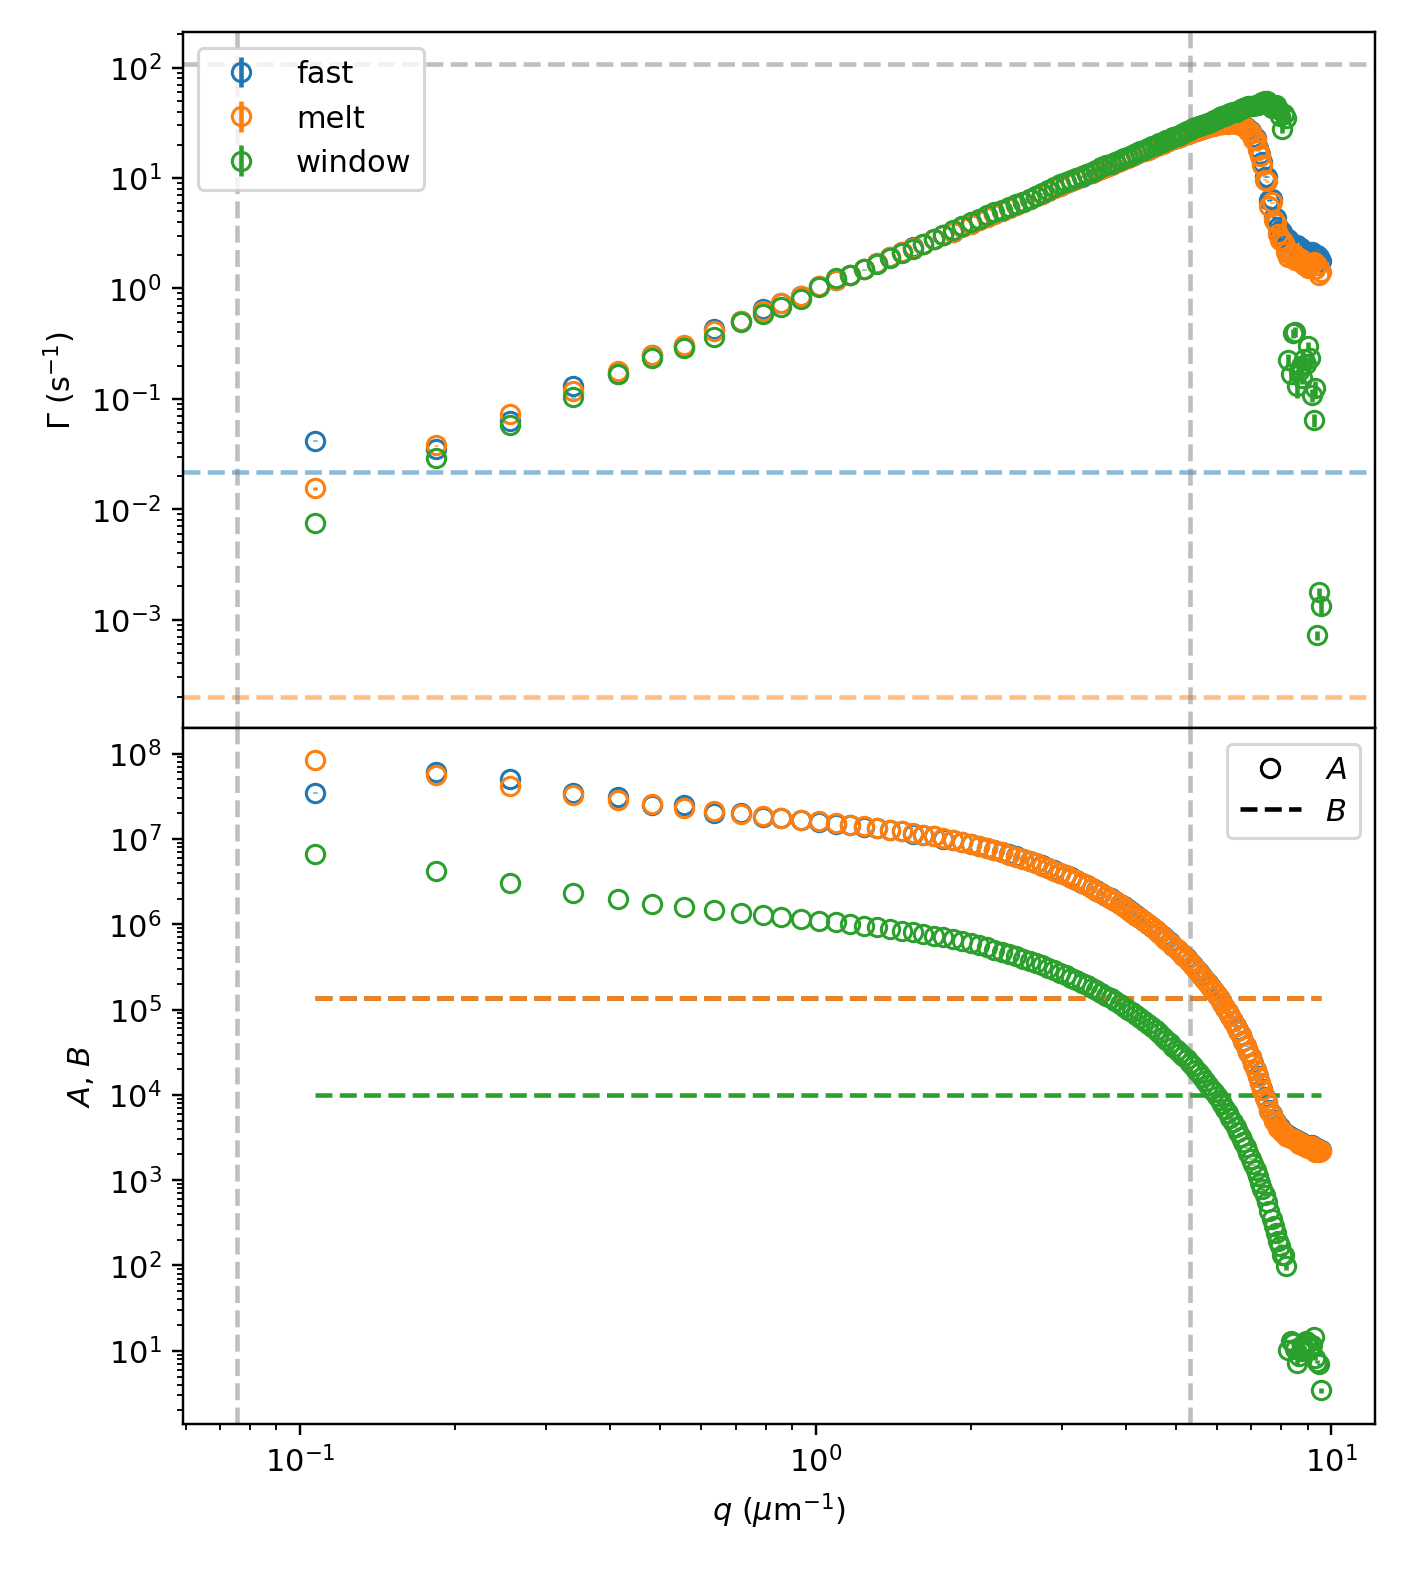

In [18]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res, labels)):
    # filter only nan and non-successful fits
    tmp_df = fr[fr['success']].dropna()
    
    # display the full data (with transparency)
    axs[0].errorbar(
        tmp_df['k'],
        tmp_df['Gamma'],
        yerr=tmp_df['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        tmp_df['k'],
        tmp_df['A'],
        yerr=tmp_df['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        tmp_df['k'],
        np.full_like(tmp_df['B'], fill_value=tmp_df['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend(loc='upper left')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

# plot Gamma limits
axs[0].axhline(gamma_T[0], color='C0', linestyle='--', alpha=0.5)
axs[0].axhline(gamma_T[1], color='C1', linestyle='--', alpha=0.5)
axs[0].axhline(gamma_0, color='gray', linestyle='--', alpha=0.5)

# plot q limits
axs[0].axvline(x=q_min, color='gray', linestyle='--', alpha=0.5)
axs[0].axvline(x=q_max, color='gray', linestyle='--', alpha=0.5)
axs[1].axvline(x=q_min, color='gray', linestyle='--', alpha=0.5)
axs[1].axvline(x=q_max, color='gray', linestyle='--', alpha=0.5)

fig.tight_layout();

The blue and orange dashed lines in the upper plot are the $\gamma_T$ limits for the fast and melt/window data, respectively.
The limit $\gamma_T^{\mathrm{(fast)}}$, as we saw in the first tutorial, would filter out the first point, which is in fact off.

What is notable is the effect of image windowing on the high-$q$ limit.
While the original data display a drop in correspondence to the $q_{\mathrm{max}} = 2 \pi \mathrm{NA}_o / \lambda$ limit, the relaxation rate obtained from the fit after windowing shows a nice diffusive behavior in a larger $q$ window, sensibly exceeding the threshold set by the diffraction limit!

We can again filter the fit results as we saw in the first tutorial.

In [19]:
# update limits
q_min = np.array([2, 1, 1]) * (2 * np.pi / L)   # we remove the first q point from 'fast'
q_max = np.array([q_max, q_max, 6.85])          # we extend the upper limit of q for the window results

# filter fit results
fit_res_filtered = []

for fr, qm, qM, gT in zip(fit_res, q_min, q_max, gamma_T):
    # remove non-succesful fits and nans
    tmp_df = fr[fr['success']].dropna()
    
    # filter q range
    tmp_df = tmp_df[(tmp_df['k'] >= qm) & (tmp_df['k'] <= qM)]
    
    # filter Gamma range
    tmp_df = tmp_df[(tmp_df['Gamma'] >= gT) & (tmp_df['Gamma'] <= gamma_0)]
    
    # append to list
    fit_res_filtered.append(tmp_df)

<IPython.core.display.Javascript object>


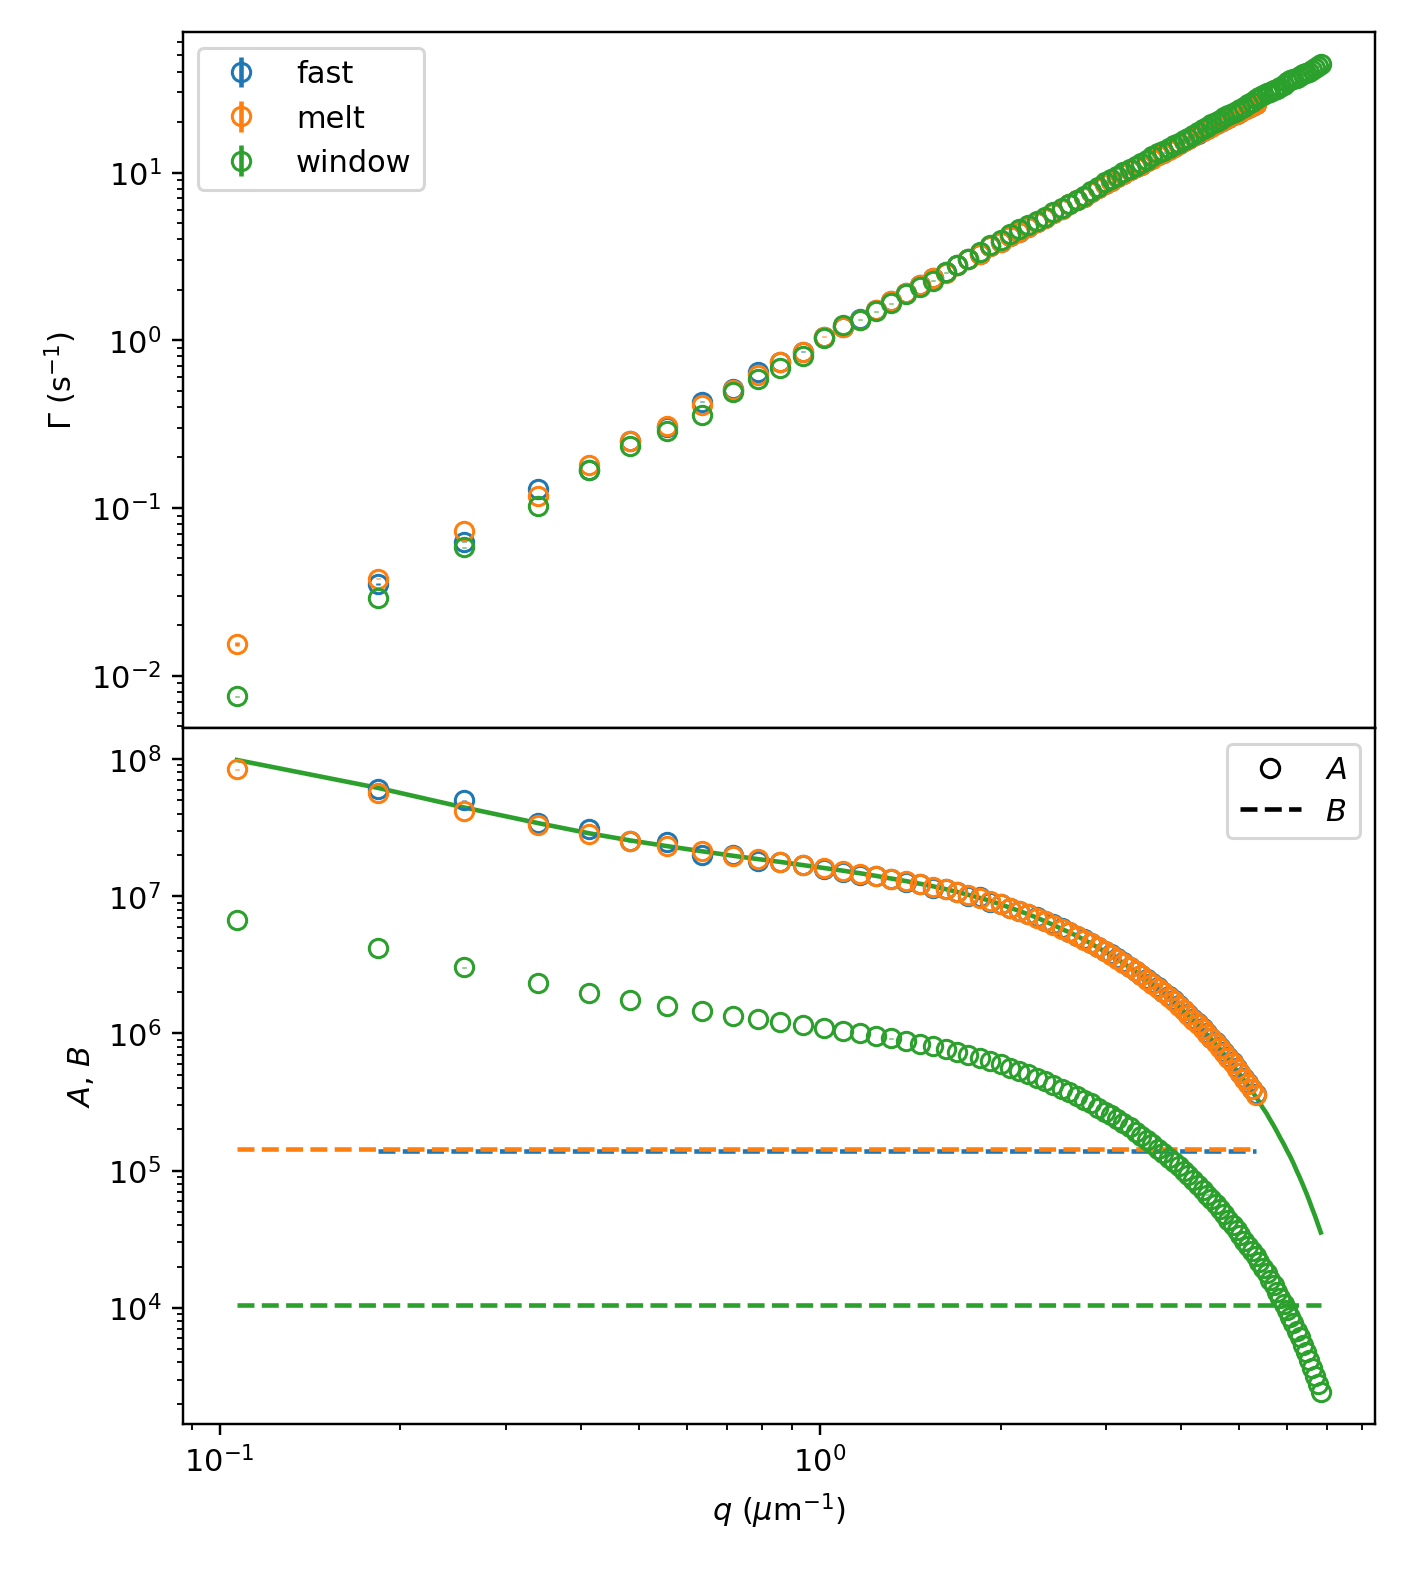

In [20]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res_filtered, labels)):
    
    # display the full data (with transparency)
    axs[0].errorbar(
        fr['k'],
        fr['Gamma'],
        yerr=fr['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        fr['k'],
        fr['A'],
        yerr=fr['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        fr['k'],
        np.full_like(fr['B'], fill_value=fr['B'].mean()),
        f'C{n}--',
    )
    
# also show amplitude from windowing output scaled
axs[1].plot(
    fit_res_filtered[2]['k'],
    fit_res_filtered[2]['A'] / np.mean(window**2),
    'C2-',
)

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

fig.tight_layout();

Notice that the amplitude obtained after image windowing can be rescaled on top of the structure function of the unprocessed images simply by dividing $A(q)$ by the spatial average of the squared window function $\langle W(\mathbf{x}) \rangle_{\mathbf{x}}$.

### 2.D. Fit $\Gamma$ to retrieve the diffusion coefficient

For *purely diffusive dynamics*, the relaxation rate and diffusion coefficient $D$ are connected via

$$
\Gamma = D q^2 .
$$
By fitting $\Gamma$ using this power law model, we can extract the diffusion coefficient.

In [21]:
# fit Gamma using Dq^2 model
# we actually fit the logarithm of Gamma, so we define log(Dq^2)
# define model
def log_Dq2(x, D):
    return np.log(D * x**2)
model_Gamma = lmfit.Model(log_Dq2, nan_policy="omit")
model_Gamma.set_param_hint("D", min=0.0, value=1.0)

# fit Gamma
D = []
D_err = []
for fr in fit_res_filtered:
    Gamma_fit_res = fit(model_Gamma,
                        xdata=fr['k'],
                        ydata=np.log(fr['Gamma']),
                        weights=fr['Gamma']/fr['Gamma_stderr'])
    D.append(Gamma_fit_res.params["D"].value)
    D_err.append(Gamma_fit_res.params["D"].stderr)

<IPython.core.display.Javascript object>


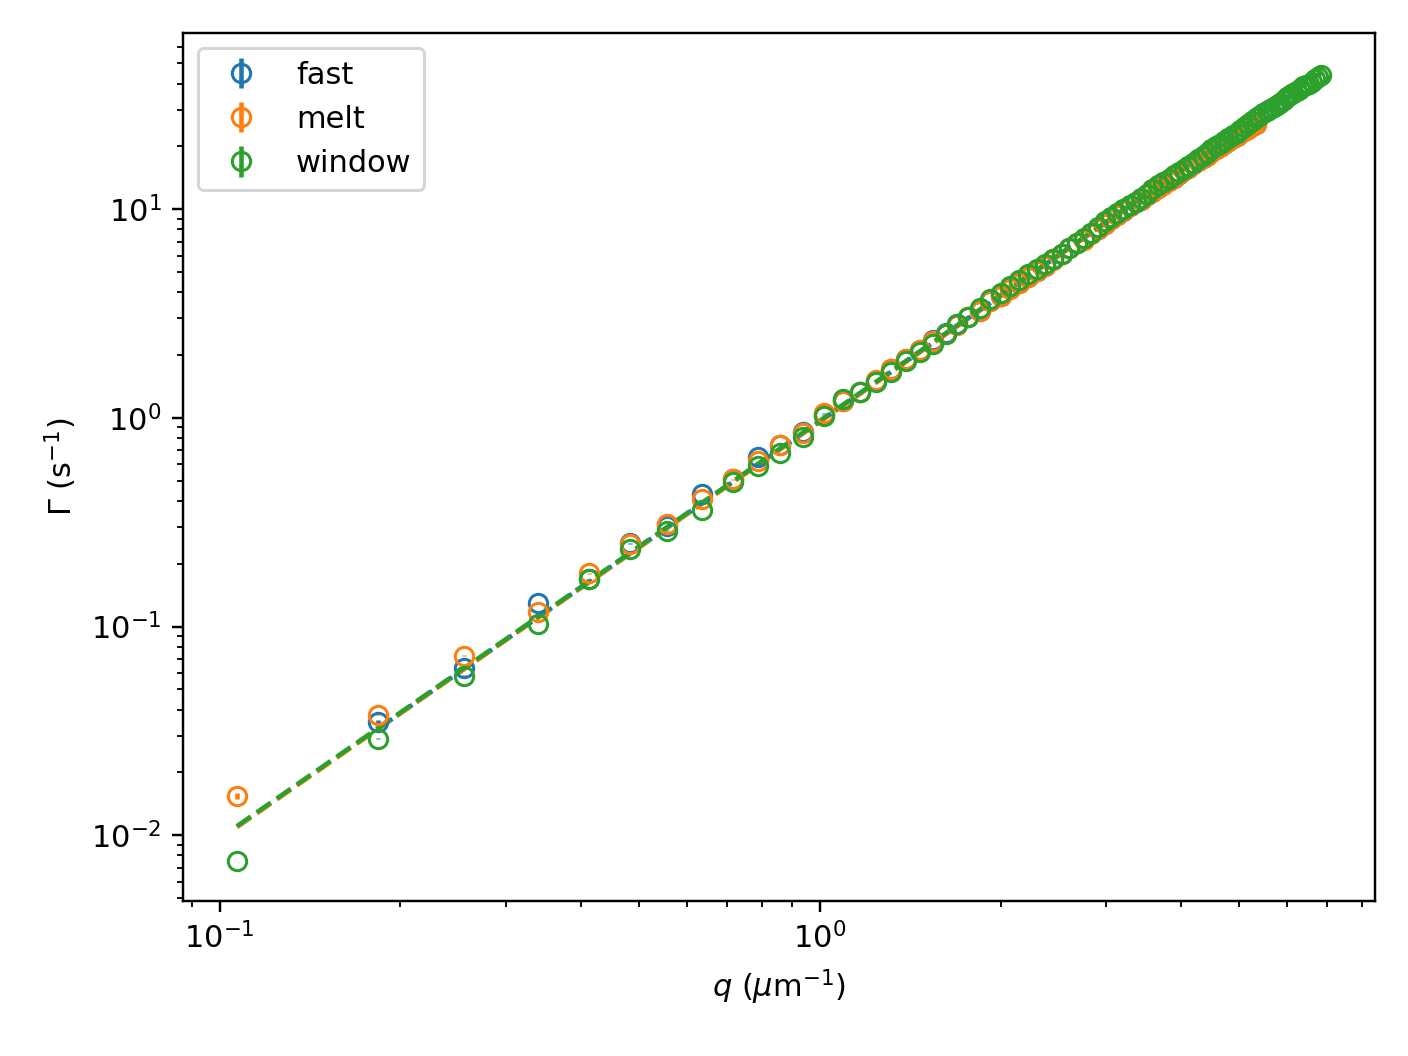

In [22]:
# plot again Gamma with the fit lines
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n, (frf, label) in enumerate(zip(fit_res_filtered, labels)):
    ax.errorbar(
        frf['k'],
        frf['Gamma'],
        yerr=frf['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    ax.plot(
        frf['k'],
        D[n] * frf['k']**2,
        f'C{n}--'
    )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$\Gamma$ (s$^{-1}$)')

ax.legend()

fig.tight_layout();

In [23]:
# display measured diffusion coefficients
print(f'Label \t D (µm²/s)')
print('-'*22)

for label, d, derr in zip(labels, D, D_err):
    print(f'{label:<9}{d:.3f} ± {derr:.3f}')

print('-'*22)

# display estimated diffusion coefficient
T = 20          # temperature (Celsius)
T += 273.15     # convert temperature to kelvin
kB = 1.38e-23   # Boltzmann constant (J / K)
kT = kB * T     # thermal energy (J)
eta = 1.78e-3    # viscosity (Pa s)
D_nom = 252e-9  # nominal diameter (m)

D_est = kT / (3 * np.pi * eta * D_nom)

D_est *= 1e12  # convert from m2/s to um2/s

print(f'\nEstimated diffusion coefficient: {D_est:.3f} μm²/s')

Label 	 D (µm²/s)
----------------------
fast     0.962 ± 0.003
melt     0.959 ± 0.002
window   0.969 ± 0.002
----------------------

Estimated diffusion coefficient: 0.957 μm²/s


The diffusion coefficient obtained in the three cases is in good agreement with the estimated value $D = k_B T / (3 \pi \eta D_h) = 0.957 \, \mathrm{\mu m^2/s}$.

# (\*) Figures for paper

This last section is not part of the tutorial. If you are interested in getting the images used for the particle sizing section of our publication, feel free to set the following flag to `True` and run the cells below. You will need the `scienceplots` package, which is not among the ones required for these tutorials. You can install it through `pip`.

In [24]:
save_figures = False

In [25]:
if save_figures:
    # --- imports ---
    import scienceplots

    plt.style.use(['science', 'nature', 'vibrant'])
    mpl.rcParams['lines.markeredgewidth'] = 0.7
    
    # create FIGS directory
    os.makedirs('FIGS', exist_ok=True)

### Export images

In [26]:
if save_figures:
    # --- save comparison f(q,dt) / fit ---
    fig = plt.figure()
    fig.set_figheight((len(aa) / 2) * fig.get_figheight())
    gs = fig.add_gridspec(len(aa), hspace=0)
    axs = gs.subplots(sharex=True)

    # select range of wave vectors indices
    k_min = 0.17
    k_max = 5.2

    idx_min = np.argmin(np.abs(aa[0].k - k_min))
    idx_max = np.argmin(np.abs(aa[0].k - k_max))
    k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

    cspace = color_space(len(k_list))

    # plot curves
    for ax, a, ar, fr, mr, l in zip(axs, aa, aa_resampled, fit_res, model_res, labels):
        for k_idx, c in zip(k_list, cspace):
            # calculate intermediate scattering function
            fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
            fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
            # plot
            ax.plot(ar.tau, fqt, '.', color=c)
            ax.plot(a.tau, fqt_fit, '-', color=c)
        
            # misc
            ax.set_ylabel(r'$f(\Delta t; q)$')
            ax.set_ylim(-0.1, 1.1)
            # label
            at = AnchoredText(l, prop=dict(size=10), frameon=True, loc='upper right')
            ax.add_artist(at)
            # custom legend
            custom_lines = [
                Line2D([0], [0], marker='.', linestyle='none', color='black', label='data'),
                Line2D([0], [0], linestyle='-', color='black', label='fit'),
            ]
            ax.legend(handles=custom_lines, labelspacing=0.4, loc='center right')
        
    axs[-1].set_xscale('log')
    axs[-1].set_xlabel(r'$\Delta t$ (s)')

    fig.tight_layout()
    
    fig.savefig('FIGS/fqt.pdf', dpi=600)

In [27]:
if save_figures:
    # --- save fit parameters ---
    fig = plt.figure()
    fig.set_figheight(1.7 * fig.get_figheight())
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True)
    
    # add inset
    axin = axs[0].inset_axes([0.6, 0.10, 0.37, 0.37])
    
    for n, (fr, frf, d, label) in enumerate(zip(fit_res, fit_res_filtered, D, labels)):
        # invert order of layers to highlight windowing output
        zorder = len(labels)-n-1
        # plot Gamma
        axs[0].plot(frf['k'], frf['Gamma'],
                    f'C{n}o', markerfacecolor='none',
                    zorder=zorder,
                    label=label)
        
        # plot fit line
        axs[0].plot(frf['k'], d * frf['k']**2,
                    f'C{n}--')
        
        # make zoom of Gamma
        axin.plot(fr['k'], fr['Gamma'],
                  f'C{n}o', markerfacecolor='none',
                  zorder=2*zorder,
                  alpha=0.2)
        axin.plot(frf['k'], frf['Gamma'],
                  f'C{n}o', markerfacecolor='none',
                  zorder=2*zorder-1)
        
        
        # plot A
        axs[1].plot(frf['k'], frf['A'],
                    f'C{n}o', markerfacecolor='none',
                    zorder=zorder)
        
        # scale A if window
        if label == 'window':
            axs[1].plot(frf['k'], frf['A'] / np.mean(window**2),
                        f'C{n}-')
    
    # plot qmax limit
    qM = q_max[0]
    axs[0].axvline(x=qM, color='gray', linestyle='--', alpha=0.8)
    axin.axvline(x=qM, color='gray', linestyle='--', alpha=0.8)
    axs[1].axvline(x=qM, color='gray', linestyle='--', alpha=0.8)
    
    # settings
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
    axs[0].legend(loc='center left')
    axin.set_xscale('log')
    axin.set_yscale('log')
    axin.set_xlim(4.5, 9.5)
    axin.set_ylim(1, 100)
    axin.set_xticks([5, 6, 7, 8, 9])
    axin.set_xticklabels([5, 6, 7, 8, 9])
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
    axs[1].set_ylabel(r'$A$')
    
    # plot panel label   
    at = [
        AnchoredText("a)", prop=dict(size=10), frameon=False, loc='upper left'),
        AnchoredText("b)", prop=dict(size=10), frameon=False, loc='lower left'),
    ]
    for a, _at in zip(axs, at):
        a.add_artist(_at)
    
    fig.tight_layout()
    
    fig.savefig('FIGS/Gamma_A.pdf', dpi=600)